<a href="https://colab.research.google.com/github/makumaku/uranai/blob/master/%E4%BB%8A%E6%97%A5%E3%81%AE%E5%8D%A0%E3%81%84%E3%82%AB%E3%82%A6%E3%83%B3%E3%83%88%E3%83%80%E3%82%A6%E3%83%B3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# グラフ表示のために必要
!rm /root/.cache/matplotlib/fontlist-v300.json
!apt-get -y install fonts-ipafont-gothic
# ランタイムを再起動すること。

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-410
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  fonts-ipafont-mincho
The following NEW packages will be installed:
  fonts-ipafont-gothic fonts-ipafont-mincho
0 upgraded, 2 newly installed, 0 to remove and 16 not upgraded.
Need to get 8,251 kB of archives.
After this operation, 28.7 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 fonts-ipafont-gothic all 00303-18ubuntu1 [3,526 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 fonts-ipafont-mincho all 00303-18ubuntu1 [4,725 kB]
Fetched 8,251 kB in 1s (7,483 kB/s)
Selecting previously unselected package fonts-ipafont-gothic.
(Reading database ... 130942 files and directories currently installed.)
Preparing to unpack .../fonts-ipafont-g

In [0]:
# google driveへマウント
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 


import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
#print(os.listdir("../alexander_999_taku"))

# Any results you write to the current directory are saved as output.

In [20]:
# PC上のデータをアップロード
# データは毎日エクセルで更新した情報をアップロード
# 動作が不安定になったが、二回実行すると動くので一旦放置
# 動かなくなれば、ドライブをマウントする方法へ変更
# やりたいことによってアップロード対象が異なるため注意
# モデル予想時： data274.csv,data275.csvなどのデータ
# 分析時：countdown_num.csv,countdown_raw.csv
from google.colab import files
f=files.upload()

Saving countdown_raw.csv to countdown_raw.csv


ここからモデル予想

In [4]:
# アップロードしたデータを読みこむ
# dataの名称は都度変更すること
data = pd.read_csv("data274.csv", encoding="shift-jis", engine = "python")
data_predict_test = pd.read_csv("data275.csv", encoding="shift-jis", engine = "python")

# 順序性による悪影響を受けないようにするため、シャッフルを実施。
data = data.sample(frac=1, random_state=0)
# 項番の再抽出が必要になる場合に備えるため項番を残しつつ、インデックスの振り直しをする。
data = data.reset_index()
data.head()

,index,項番,年,月,日,牡牛座3日1位数,牡牛座7日1位数,牡牛座30日1位数,牡牛座365日1位数,牡牛座3日成績,牡牛座7日成績,牡牛座30日成績,牡牛座1日成績,牡牛座_絶対値_前日-前々日,牡牛座_+-_前日-前々日,牡牛_3日_EMA,牡牛_7日_EMA,牡牛_30日_EMA,牡羊座3日1位数,牡羊座7日1位数,牡羊座30日1位数,牡羊座365日1位数,牡羊座3日成績,牡羊座7日成績,牡羊座30日成績,牡羊座前日成績,牡羊座_絶対値_前日-前々日,牡羊座_+-_前日-前々日,牡羊_3日_EMA,牡羊_7日_EMA,牡羊_30日_EMA,乙女座3日1位数,乙女座7日1位数,乙女座30日1位数,乙女座365日1位数,乙女座3日成績,乙女座7日成績,乙女座30日成績,乙女座前日成績,乙女座_絶対値_前日-前々日,...,火の属性_30日_EMA,土の属性3日1位数,土の属性7日1位数,土の属性30日1位数,土の属性365日1位数,土の属性3日成績,土の属性7日成績,土の属性30日成績,土の属性前日成績,土の属性3日_EMA,土の属性_7日_EMA,土の属性_30日_EMA,風の属性3日1位数,風の属性7日1位数,風の属性30日1位数,風の属性365日1位数,風の属性3日成績,風の属性7日成績,風の属性30日成績,風の属性前日成績,風の属性3日_EMA,風の属性_7日_EMA,風の属性_30日_EMA,水の属性3日1位数,水の属性7日1位数,水の属性30日1位数,水の属性365日1位数,水の属性3日成績,水の属性7日成績,水の属性30日成績,水の属性前日成績,水の属性3日_EMA,水の属性_7日_EMA,水の属性_30日_EMA,月星座,月星座同属性1,月星座同属性2,星座,当日の回答,星座.1
0,1946,1946,2012,8,17,1,2,3,3,18,40,183,12,7,0,8.280271,6.997433,6.100000,0,0,2,2,27,51,194,5,5,1,7.093548,6.968038,6.466667,0,1,4,4,19,43,188,10,6,...,19.633333,1,3,9,9,55,123,573,30,22.999394,20.787327,19.100000,0,2,7,7,65,133,564,9,16.706667,17.760057,18.800000,1,1,5,5,44,132,614,27,19.636220,19.620789,20.466667,5,9,1,5,1,2012/8/17
1,666,666,2017,4,14,0,0,3,31,18,56,194,3,3,1,5.085480,6.295922,6.492355,0,0,2,25,23,34,200,9,1,1,7.893042,6.623667,6.423896,0,0,3,29,16,48,185,5,1,...,19.579086,0,0,7,88,55,166,608,12,16.510561,19.785479,20.338505,1,4,8,99,63,112,584,28,23.626824,20.100821,19.380519,2,2,9,95,44,155,549,9,13.025461,17.282016,18.701889,9,1,5,1,4,2017/4/14
2,22,22,2019,8,29,0,1,3,34,13,35,191,2,4,1,3.536041,4.618261,6.283927,0,0,3,30,30,53,203,10,1,1,9.881881,8.617428,7.002271,1,1,2,29,8,33,183,4,1,...,20.616864,1,2,8,91,35,109,561,13,12.424781,14.313404,18.542395,0,0,6,92,88,175,614,29,28.595009,25.904056,21.068596,2,3,8,94,29,107,558,9,10.056423,13.410543,17.772145,5,9,1,6,5,2019/8/29
3,104,104,2019,5,24,0,0,3,35,12,42,167,2,1,1,3.698962,5.050786,5.617231,1,1,3,30,22,49,199,12,3,0,9.118512,7.765206,6.934528,1,1,3,29,16,44,194,4,3,...,20.521699,2,2,9,93,40,130,546,7,11.309962,15.258759,17.803789,0,1,6,94,73,150,619,30,26.723965,23.640276,20.978081,0,2,7,89,59,129,567,14,16.867449,18.063775,18.696431,11,3,7,3,11,2019/5/24
4,702,702,2017,2,23,0,1,2,32,22,44,201,2,6,1,5.195855,6.246850,6.661992,0,0,1,24,16,45,203,9,5,0,6.931229,6.644555,6.782776,1,1,4,29,20,44,199,1,10,...,19.320196,1,2,7,90,68,145,610,9,17.860566,20.234171,20.359288,0,2,8,99,59,125,559,33,23.260737,19.666236,18.501634,0,1,9,92,71,151,579,16,20.492238,20.919484,19.818882,10,2,6,12,10,2017/2/23


In [0]:
# 特徴量と回答の分離
X = data.drop(["当日の回答"], axis=1)
# エクセルで使用した不要なデータは削除する。
X = X.drop(["星座.1"], axis=1)

Y = data[["当日の回答"]]

In [6]:
# LightGBMでのモデル作成
from sklearn.model_selection import StratifiedKFold
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# まずは全データセットで学習
# trainとtestに分割
X_train, X_test, y_train, y_test = train_test_split(
        X, Y, test_size=0.2, random_state=0)

lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)

# LightGBM parameters

params = {
        'task': 'train',
        'boosting_type': 'gbdt',
        'objective': 'multiclass',
        'metric': {'multi_logloss'},
        'num_class': 13,
        'learning_rate': 0.01,
        'num_leaves': 13,
        'min_data_in_leaf': 5,
        'num_iteration': 1000,
        'verbose': 0
}


# Kfoldで分割して汎化性能があるか確認
stack_xs_test = pd.DataFrame()
stack_y_pred = []
stack_data = pd.DataFrame()
stack_stack_data = pd.DataFrame()

#skf = StratifiedKFold(n_splits=3, shuffle=True)
skf = StratifiedKFold(n_splits=3, shuffle=False)
for train_index, test_index in skf.split(X, Y):
    xs_train = X.iloc[train_index]
    y_train = Y.iloc[train_index]
    xs_test = X.iloc[test_index]
    y_test = Y.iloc[test_index] 
    xs_train_index = xs_train[["index"]]
    xs_train = xs_train.drop(["index"], axis=1)
    lgb_train = lgb.Dataset(xs_train, y_train)
    xs_test_index = xs_test[["index"]]
    xs_test = xs_test.drop(["index"], axis=1)
    lgb_eval = lgb.Dataset(xs_test, y_test, reference=lgb_train)
    gbm = lgb.train(params, lgb_train, num_boost_round=50, valid_sets=lgb_eval,early_stopping_rounds=20)
    y_pred = gbm.predict(xs_test, num_iteration=gbm.best_iteration)
    # 1位だけじゃなく順位も取得したいため、予想順位をy_check_percent_predに格納
    y_check_percent_pred = y_pred
    
    # y_predは順位のみ
    y_pred = np.argmax(y_pred, axis=1)
    # 1位になる確率の低い順に星座を並べた変数
    y_pred_percent_pred_sort = y_check_percent_pred.argsort()
    # 1位になる星座の確率をソートしたものを格納
    y_pred_sort = np.sort(y_check_percent_pred)
    print("Accuracy")
    print(accuracy_score(y_test, y_pred))
    
    # 全データを再度分析するために、学習データ・テストデータ・予想データを取得
    # 学習データのインデックスが邪魔になるため削除
    xs_test = xs_test.reset_index(drop=True)
    xs_test_index = xs_test_index.reset_index(drop=True)
    
    # テストデータのインデックスが邪魔になるため削除
    y_test = y_test.reset_index(drop=True)
    
    # Kfoldのデータをstack_dataへ格納する。
    stack_data = pd.DataFrame()
    # 各データをdataframeへ変換
    y_pred_df = pd.DataFrame(y_pred)
    df_y_pred_percent_pred_sort = pd.DataFrame(y_pred_percent_pred_sort)
    df_y_pred_sort = pd.DataFrame(y_pred_sort)
    y_check_percent_pred_df = pd.DataFrame(y_check_percent_pred)
    stack_data = pd.concat([xs_test, y_pred_df, y_test, y_check_percent_pred_df, df_y_pred_sort, df_y_pred_percent_pred_sort], axis=1)
    # 分割したデータを結合する。
    stack_stack_data = pd.concat([stack_stack_data, stack_data])
    

/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's multi_logloss: 2.47666
Training until validation scores don't improve for 20 rounds.
[2]	valid_0's multi_logloss: 2.46927
[3]	valid_0's multi_logloss: 2.46192
[4]	valid_0's multi_logloss: 2.45487
[5]	valid_0's multi_logloss: 2.44808
[6]	valid_0's multi_logloss: 2.44163
[7]	valid_0's multi_logloss: 2.43502
[8]	valid_0's multi_logloss: 2.42931
[9]	valid_0's multi_logloss: 2.42355
[10]	valid_0's multi_logloss: 2.41729
[11]	valid_0's multi_logloss: 2.411
[12]	valid_0's multi_logloss: 2.40577
[13]	valid_0's multi_logloss: 2.39962
[14]	valid_0's multi_logloss: 2.39454
[15]	valid_0's multi_logloss: 2.38892
[16]	valid_0's multi_logloss: 2.38349
[17]	valid_0's multi_logloss: 2.37829
[18]	valid_0's multi_logloss: 2.37321
[19]	valid_0's multi_logloss: 2.36803
[20]	valid_0's multi_logloss: 2.36318
[21]	valid_0's multi_logloss: 2.35854
[22]	valid_0's multi_logloss: 2.35377
[23]	valid_0's multi_logloss: 2.34914
[24]	valid_0's multi_logloss: 2.3448
[25]	valid_0's multi_logloss: 2.34031


In [7]:
# 予想を実行する。
# 的中率算出時に小数表示をするために設定を変更
# 
np.set_printoptions(formatter={'float': '{:.2f}'.format})
X_data_test = data_predict_test.drop(["当日の回答","星座.1"], axis=1)
y_pred_today = gbm.predict(X_data_test, num_iteration=gbm.best_iteration)
y_pred_today_answer = np.argmax(y_pred_today, axis=1)
print("順位を下から表示。番号は0から(どれでもない,牡羊,牡牛,双子,蟹,獅子,乙女,天秤,蠍,射手,山羊,水瓶,魚)")
print(y_pred_today[0].argsort())
print("各星座の的中率(どれでもない,牡羊,牡牛,双子,蟹,獅子,乙女,天秤,蠍,射手,山羊,水瓶,魚)")
print(y_pred_today[0])

順位を下から表示。番号は0から(どれでもない,牡羊,牡牛,双子,蟹,獅子,乙女,天秤,蠍,射手,山羊,水瓶,魚)
[ 0  5  6  7  4  2  9  1 10 12  8  3 11]
各星座の的中率(どれでもない,牡羊,牡牛,双子,蟹,獅子,乙女,天秤,蠍,射手,山羊,水瓶,魚)
[0.00 0.07 0.05 0.14 0.05 0.02 0.03 0.04 0.09 0.06 0.07 0.29 0.09]


ここから分析

In [0]:
# 分析用にアップロードしたデータを読みこむ
countdown_raw = pd.read_csv("countdown_raw.csv", encoding="shift-jis", engine = "python")
countdown_num = pd.read_csv("countdown_num.csv", encoding="shift-jis", engine = "python")

In [0]:
# アップロードされたデータの確認
# 不要なデータは削除すること
!ls -ltr /content/
!rm -fr /content/countdown_raw.csv

total 5896
drwxr-xr-x 1 root root    4096 Aug 27 16:17 sample_data
-rw-r--r-- 1 root root 2832067 Sep 29 13:21 data272.csv
-rw-r--r-- 1 root root    4255 Sep 29 13:21 data273.csv
-rw-r--r-- 1 root root 1149881 Sep 29 13:32 countdown.csv
-rw-r--r-- 1 root root 2035998 Sep 29 13:33 countdown_plus.csv


In [0]:
countdown_raw.head()

,年,月,日,1位,2位,3位,4位,5位,6位,7位,8位,9位,10位,11位,12位,星座
0,2019,9,27,乙女,牡牛,山羊,蠍,蟹,魚,獅子,天秤,射手,牡羊,双子,水瓶,7
1,2019,9,26,射手,牡羊,獅子,蟹,水瓶,天秤,双子,蠍,山羊,牡牛,魚,乙女,7
2,2019,9,25,獅子,天秤,双子,射手,牡羊,水瓶,魚,乙女,蠍,山羊,蟹,牡牛,7
3,2019,9,24,蟹,蠍,牡牛,魚,山羊,乙女,水瓶,牡羊,獅子,双子,射手,天秤,7
4,2019,9,23,蠍,魚,蟹,乙女,牡牛,双子,山羊,水瓶,天秤,射手,獅子,牡羊,7


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f5f426a76d8>,
      dtype=object)

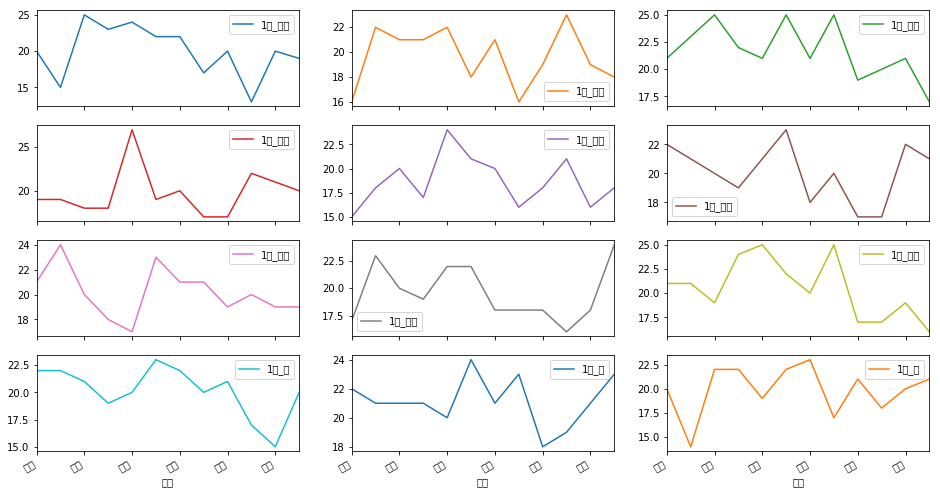

In [0]:
# 当日の星座によって各星座の順位が異なっている可能性があるため調査
# 必要なデータを残す。
countdown_1_con = countdown_raw[['星座','1位']]
# 1位の星座をonehot化する
countdown_1_con = pd.get_dummies(countdown_1_con, drop_first=False, columns=['1位'], prefix='1位', prefix_sep='_')
# 当日の星座でgroupbyする
countdown_1_con_grouped = countdown_1_con.groupby('星座')
# sumすることで、各星座が当日の星座ごとに1位になった回数を算出
sum = countdown_1_con_grouped.sum()
sum_graph = sum.rename(index={1: "牡羊", 2: "牡牛", 3: "双子", 4: "蟹", 5: "獅子", 6: "乙女", 7: "天秤", 8: "蠍", 9: "射手", 10: "山羊", 11: "水瓶", 12: "魚", })
sum_graph.head(12)
# それぞれのデータをグラフ表示
sum_graph.plot(figsize=(16, 9),subplots=True, layout=(4, 3))

In [0]:
countdown_raw.head()

,項番,年,月,日,1位,2位,3位,4位,5位,6位,7位,8位,9位,10位,11位,12位,牡牛座3日1位数,牡牛座7日1位数,牡牛座30日1位数,牡牛座365日1位数,牡牛座3日成績,牡牛座7日成績,牡牛座30日成績,牡牛座1日成績,牡牛座_絶対値_前日-前々日,牡牛座_+-_前日-前々日,牡牛_3日_EMA,牡牛_7日_EMA,牡牛_30日_EMA,牡羊座3日1位数,牡羊座7日1位数,牡羊座30日1位数,牡羊座365日1位数,牡羊座3日成績,牡羊座7日成績,牡羊座30日成績,牡羊座前日成績,牡羊座_絶対値_前日-前々日,牡羊座_+-_前日-前々日,牡羊_3日_EMA,...,火の属性_30日_EMA,土の属性3日1位数,土の属性7日1位数,土の属性30日1位数,土の属性365日1位数,土の属性3日成績,土の属性7日成績,土の属性30日成績,土の属性前日成績,土の属性3日_EMA,土の属性_7日_EMA,土の属性_30日_EMA,風の属性3日1位数,風の属性7日1位数,風の属性30日1位数,風の属性365日1位数,風の属性3日成績,風の属性7日成績,風の属性30日成績,風の属性前日成績,風の属性3日_EMA,風の属性_7日_EMA,風の属性_30日_EMA,水の属性3日1位数,水の属性7日1位数,水の属性30日1位数,水の属性365日1位数,水の属性3日成績,水の属性7日成績,水の属性30日成績,水の属性前日成績,水の属性3日_EMA,水の属性_7日_EMA,水の属性_30日_EMA,月星座,月星座同属性1,月星座同属性2,星座,当日の回答,星座.1
0,1,2019,9,27,乙女,牡牛,山羊,蠍,蟹,魚,獅子,天秤,射手,牡羊,双子,水瓶,0,1,2,33,25,36,199,10,2,1,8.866308,7.082212,6.736422,0,0,2,30,15,48,201,2,3,1,4.381373,...,19.281343,0,2,5,88,75,125,579,31,26.766899,22.399565,20.055684,0,1,5,91,58,152,615,18,17.980360,19.315281,19.713153,1,2,9,93,57,119,566,23,20.87008,19.117450,18.949819,6,10,2,7,6,2019/9/27
1,2,2019,9,26,射手,牡羊,獅子,蟹,水瓶,天秤,双子,蠍,山羊,牡牛,魚,乙女,0,1,2,33,20,32,201,12,9,0,7.732616,6.109616,6.511348,0,0,2,30,25,49,203,5,3,1,6.762747,...,20.197298,0,2,5,89,60,118,580,30,22.533798,19.532753,19.300904,0,1,6,91,63,147,603,11,17.960721,19.753708,19.831302,2,2,9,93,40,128,568,27,18.74016,17.823266,18.670496,6,10,2,7,9,2019/9/26
2,3,2019,9,25,獅子,天秤,双子,射手,牡羊,水瓶,魚,乙女,蠍,山羊,蟹,牡牛,0,1,2,33,11,29,202,3,2,1,3.465232,4.146155,6.132820,0,0,2,30,25,46,207,8,4,1,8.525493,...,20.900560,0,2,5,89,52,119,574,14,15.067595,16.043671,18.563035,1,1,7,91,63,151,609,29,24.921441,22.671610,20.440357,2,2,9,94,39,126,551,7,10.48032,14.764355,18.096048,5,9,1,7,5,2019/9/25
3,4,2019,9,24,蟹,蠍,牡牛,魚,山羊,乙女,水瓶,牡羊,獅子,双子,射手,天秤,1,1,2,33,9,30,204,5,2,0,3.930464,4.528207,6.348876,0,0,2,30,26,46,210,12,7,0,9.050987,...,20.410944,1,2,5,89,44,120,583,16,16.135191,16.724894,18.877727,1,1,8,91,64,151,593,23,20.842883,20.562147,19.850037,1,2,8,94,47,125,558,6,13.96064,17.352473,18.861292,5,9,1,7,4,2019/9/24
4,5,2019,9,23,蠍,魚,蟹,乙女,牡牛,双子,山羊,水瓶,天秤,射手,獅子,牡羊,1,1,2,33,6,33,213,3,2,0,2.860928,4.370942,6.441902,0,0,2,30,21,41,195,5,4,1,6.101974,...,19.542733,2,2,5,89,34,121,608,22,16.270381,16.966526,19.076191,1,2,8,92,71,138,571,11,18.685765,19.749529,19.632798,0,1,8,93,56,152,586,26,21.92128,21.136631,19.748278,4,8,12,7,8,2019/9/23


In [14]:
# 各星座の日(例えばうお座だと2/19～3/20)で成績が偏る可能性を考慮し、groupbyし、平均を出す。
grouped = countdown_num.groupby('星座')
mean = grouped.mean()
mean.head()

,項番,年,月,日,1位,2位,3位,4位,5位,6位,7位,8位,9位,10位,11位,12位,2座3日1位数,2座7日1位数,2座30日1位数,2座365日1位数,2座3日成績,2座7日成績,2座30日成績,2座1日成績,2座_絶対値_前日-前々日,2座_+-_前日-前々日,2_3日_EMA,2_7日_EMA,2_30日_EMA,1座3日1位数,1座7日1位数,1座30日1位数,1座365日1位数,1座3日成績,1座7日成績,1座30日成績,1座前日成績,1座_絶対値_前日-前々日,1座_+-_前日-前々日,1_3日_EMA,...,火の属性3日_EMA,火の属性_7日_EMA,火の属性_30日_EMA,土の属性3日1位数,土の属性7日1位数,土の属性30日1位数,土の属性365日1位数,土の属性3日成績,土の属性7日成績,土の属性30日成績,土の属性前日成績,土の属性3日_EMA,土の属性_7日_EMA,土の属性_30日_EMA,風の属性3日1位数,風の属性7日1位数,風の属性30日1位数,風の属性365日1位数,風の属性3日成績,風の属性7日成績,風の属性30日成績,風の属性前日成績,風の属性3日_EMA,風の属性_7日_EMA,風の属性_30日_EMA,水の属性3日1位数,水の属性7日1位数,水の属性30日1位数,水の属性365日1位数,水の属性3日成績,水の属性7日成績,水の属性30日成績,水の属性前日成績,水の属性3日_EMA,水の属性_7日_EMA,水の属性_30日_EMA,月星座,月星座同属性1,月星座同属性2,当日の回答
星座,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,1401.563559,2014.389831,3.631356,15.911017,6.550847,6.508475,6.432203,6.330508,6.351695,6.758475,6.622881,6.745763,6.593220,6.275424,6.533898,6.296610,0.271186,0.652542,2.711864,17.944915,19.110169,44.970339,193.144068,6.279661,4.165254,0.491525,6.340320,6.376997,6.448421,0.237288,0.601695,2.576271,15.677966,18.970339,43.622881,190.105932,6.415254,3.868644,0.483051,6.343700,...,19.509099,19.395310,19.509132,0.699153,1.597458,7.161017,50.059322,59.970339,141.144068,596.491525,19.750000,19.923873,20.012632,19.895371,0.728814,1.699153,6.970339,52.745763,58.766949,135.911017,587.716102,19.745763,19.634766,19.556631,19.536846,0.826271,1.902542,8.046610,52.601695,56.940678,134.351695,569.775424,18.792373,18.932262,19.035428,19.058651,6.500000,6.635593,6.415254,6.550847
2,1391.847737,2014.337449,4.646091,15.576132,6.168724,6.695473,5.950617,6.547325,6.637860,6.473251,6.580247,6.810700,6.436214,6.465021,6.975309,6.259259,0.283951,0.641975,2.588477,18.028807,18.584362,43.502058,190.502058,6.283951,3.621399,0.456790,6.228218,6.234115,6.338815,0.255144,0.559671,2.559671,15.983539,18.991770,44.345679,187.699588,6.209877,3.954733,0.530864,6.291379,...,19.468521,19.500761,19.372286,0.716049,1.670782,6.798354,50.399177,58.716049,137.349794,598.127572,19.810700,19.658917,19.672687,19.917954,0.798354,1.876543,7.662551,53.539095,57.790123,134.930041,578.641975,19.053498,19.189560,19.231114,19.256614,0.757202,1.753086,7.600823,52.646091,58.777778,136.781893,582.444444,19.872428,19.683003,19.595438,19.453147,6.547325,6.547325,6.497942,6.168724
3,1352.611111,2014.388889,5.654762,16.170635,6.511905,6.388889,6.650794,6.460317,6.436508,6.615079,6.777778,6.365079,6.289683,6.527778,6.587302,6.388889,0.250000,0.599206,2.531746,18.031746,19.666667,45.674603,193.099206,6.543651,4.035714,0.507937,6.549164,6.532623,6.463820,0.242063,0.599206,2.492063,16.198413,19.563492,45.527778,190.952381,6.626984,3.928571,0.480159,6.553102,...,19.571922,19.525636,19.405396,0.785714,1.801587,7.083333,50.952381,59.023810,137.269841,594.035714,19.511905,19.611704,19.644026,19.801000,0.797619,1.813492,7.904762,54.111111,57.432540,134.662698,572.099206,19.305556,19.214078,19.196382,19.097179,0.702381,1.702381,7.317460,52.916667,59.063492,137.337302,591.638889,19.472222,19.602296,19.633956,19.696425,6.650794,6.507937,6.460317,6.511905
4,1341.958848,2014.358025,6.707819,15.728395,6.497942,6.534979,6.448560,6.539095,6.588477,6.526749,6.613169,6.283951,6.633745,6.502058,6.419753,6.411523,0.222222,0.497942,2.477366,18.263374,19.559671,46.061728,195.115226,6.485597,3.979424,0.481481,6.515699,6.546161,6.512120,0.218107,0.506173,2.267490,16.193416,20.242798,46.810700,200.271605,6.670782,3.909465,0.514403,6.715998,...,19.871278,19.826892,19.868695,0.695473,1.592593,7.456790,51.777778,59.053498,138.979424,583.662551,19.728395,19.725554,19.744569,19.497949,0.773663,1.843621,7.654321,54.267490,58.810700,135.810700,586.942387,19.559671,19.553347,19.503571,19.588015,0.810700,1.831276,7.596708,54.012346,56.325103,133.152263,573.411523,18.884774,18.849821,18.924968,19.045341,6.481481,6.432099,6.481481,6.497942
5,1409.015267,2014.026718,7.729008,15.759542,6.564885,6.248092,6.255725,6.500000,6.324427,6.515267,6.606870,6.538168,6.370229,6.77

In [18]:
# 
from matplotlib import pyplot as plt
import seaborn as sns

sns.set(font='IPAGothic')
mean = pd.DataFrame(mean)
mean_graph = mean.drop(["年","月","日","項番"], axis=1)
mean_graph = mean_graph.rename(index={1: "牡羊", 2: "牡牛", 3: "双子", 4: "蟹", 5: "獅子", 6: "乙女", 7: "天秤", 8: "蠍", 9: "射手", 10: "山羊", 11: "水瓶", 12: "魚", })
mean_graph.head()

,1位,2位,3位,4位,5位,6位,7位,8位,9位,10位,11位,12位,2座3日1位数,2座7日1位数,2座30日1位数,2座365日1位数,2座3日成績,2座7日成績,2座30日成績,2座1日成績,2座_絶対値_前日-前々日,2座_+-_前日-前々日,2_3日_EMA,2_7日_EMA,2_30日_EMA,1座3日1位数,1座7日1位数,1座30日1位数,1座365日1位数,1座3日成績,1座7日成績,1座30日成績,1座前日成績,1座_絶対値_前日-前々日,1座_+-_前日-前々日,1_3日_EMA,1_7日_EMA,1_30日_EMA,6座3日1位数,6座7日1位数,...,火の属性3日_EMA,火の属性_7日_EMA,火の属性_30日_EMA,土の属性3日1位数,土の属性7日1位数,土の属性30日1位数,土の属性365日1位数,土の属性3日成績,土の属性7日成績,土の属性30日成績,土の属性前日成績,土の属性3日_EMA,土の属性_7日_EMA,土の属性_30日_EMA,風の属性3日1位数,風の属性7日1位数,風の属性30日1位数,風の属性365日1位数,風の属性3日成績,風の属性7日成績,風の属性30日成績,風の属性前日成績,風の属性3日_EMA,風の属性_7日_EMA,風の属性_30日_EMA,水の属性3日1位数,水の属性7日1位数,水の属性30日1位数,水の属性365日1位数,水の属性3日成績,水の属性7日成績,水の属性30日成績,水の属性前日成績,水の属性3日_EMA,水の属性_7日_EMA,水の属性_30日_EMA,月星座,月星座同属性1,月星座同属性2,当日の回答
星座,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
牡羊,6.550847,6.508475,6.432203,6.330508,6.351695,6.758475,6.622881,6.745763,6.593220,6.275424,6.533898,6.296610,0.271186,0.652542,2.711864,17.944915,19.110169,44.970339,193.144068,6.279661,4.165254,0.491525,6.340320,6.376997,6.448421,0.237288,0.601695,2.576271,15.677966,18.970339,43.622881,190.105932,6.415254,3.868644,0.483051,6.343700,6.296285,6.343002,0.245763,0.555085,...,19.509099,19.395310,19.509132,0.699153,1.597458,7.161017,50.059322,59.970339,141.144068,596.491525,19.750000,19.923873,20.012632,19.895371,0.728814,1.699153,6.970339,52.745763,58.766949,135.911017,587.716102,19.745763,19.634766,19.556631,19.536846,0.826271,1.902542,8.046610,52.601695,56.940678,134.351695,569.775424,18.792373,18.932262,19.035428,19.058651,6.500000,6.635593,6.415254,6.550847
牡牛,6.168724,6.695473,5.950617,6.547325,6.637860,6.473251,6.580247,6.810700,6.436214,6.465021,6.975309,6.259259,0.283951,0.641975,2.588477,18.028807,18.584362,43.502058,190.502058,6.283951,3.621399,0.456790,6.228218,6.234115,6.338815,0.255144,0.559671,2.559671,15.983539,18.991770,44.345679,187.699588,6.209877,3.954733,0.530864,6.291379,6.303593,6.249334,0.209877,0.497942,...,19.468521,19.500761,19.372286,0.716049,1.670782,6.798354,50.399177,58.716049,137.349794,598.127572,19.810700,19.658917,19.672687,19.917954,0.798354,1.876543,7.662551,53.539095,57.790123,134.930041,578.641975,19.053498,19.189560,19.231114,19.256614,0.757202,1.753086,7.600823,52.646091,58.777778,136.781893,582.444444,19.872428,19.683003,19.595438,19.453147,6.547325,6.547325,6.497942,6.168724
双子,6.511905,6.388889,6.650794,6.460317,6.436508,6.615079,6.777778,6.365079,6.289683,6.527778,6.587302,6.388889,0.250000,0.599206,2.531746,18.031746,19.666667,45.674603,193.099206,6.543651,4.035714,0.507937,6.549164,6.532623,6.463820,0.242063,0.599206,2.492063,16.198413,19.563492,45.527778,190.952381,6.626984,3.928571,0.480159,6.553102,6.512684,6.387504,0.297619,0.650794,...,19.571922,19.525636,19.405396,0.785714,1.801587,7.083333,50.952381,59.023810,137.269841,594.035714,19.511905,19.611704,19.644026,19.801000,0.797619,1.813492,7.904762,54.111111,57.432540,134.662698,572.099206,19.305556,19.214078,19.196382,19.097179,0.702381,1.702381,7.317460,52.916667,59.063492,137.337302,591.638889,19.472222,19.602296,19.633956,19.696425,6.650794,6.507937,6.460317,6.511905
蟹,6.497942,6.534979,6.448560,6.539095,6.588477,6.526749,6.613169,6.283951,6.633745,6.502058,6.419753,6.411523,0.222222,0.497942,2.477366,18.263374,19.559671,46.061728,195.115226,6.485597,3.979424,0.481481,6.515699,6.546161,6.512120,0.218107,0.506173,2.267490,16.193416,20.242798,46.810700,200.271605,6.670782,3.909465,0.514403,6.715998,6.707030,6.675219,0.267490,0.609053,...,19.871278,19.826892,19.868695,0.695473,1.592593,7.456790,51.777778,59.053498,138.979424,583.662551,19.728395,19.725554,19.744569,19.497949,0.773663,1.843621,7.654321,54.267490,58.810700,135.810700,586.942387,19.559671,19.553347,19.503571,19.588015,0.810700,1.831276,7.596708,54.012346,56.325103,133.152263,573.411523,18.884774,18.849821,18.924968,19.045341,6.481481,6.432099,6.481481,6.497942
獅子,6.564885,6.248092,6.255725,6.500000,6.324427,6.515267,6.606870,6.538168,6.370229,6.774809,6.809160,6.492366,0.194656,0.469466,

In [0]:
mean.to_csv('/content/drive/My Drive/mean_20190531.csv')

In [0]:
!cat /content/output.csv

項番,年,月,日,牡牛座1日成績,牡羊座1日成績,乙女座1日成績,蟹座1日成績,魚座1日成績,山羊座1日成績,獅子座1日成績,射手座1日成績,水瓶座1日成績,双子座1日成績,天秤座1日成績,蠍座1日成績


In [28]:
df_mean = pd.DataFrame(countdown_raw.mean())
df_mean = df_mean.drop(["星座","月","日","項番"], axis=0)
df_mean_sort = df_mean.sort_values(0)
df_mean_sort = df_mean_sort.rename(columns={0: '順位平均'})
df_mean_sort.head(12)

,順位平均
山羊座3日1位数,0.233080
牡羊座3日1位数,0.243439
双子座3日1位数,0.244475
射手座3日1位数,0.245511
魚座3日1位数,0.247583
乙女座3日1位数,0.247583
水瓶座3日1位数,0.249655
牡牛座3日1位数,0.250691
蟹座3日1位数,0.250691
獅子座3日1位数,0.254834


In [0]:
# 万が一順序性が影響を与えていると正確にデータが取れないので、順序の入れ替えを行う。
data = countdown.sample(frac=1, random_state=0)
# 項番を残しつつ、インデックスの振り直しをする。
#data = data.reset_index(drop=True)
data = data.reset_index()
data.head()

,index,項番,年,月,日,牡牛座3日成績,牡牛座7日成績,牡牛座30日成績,牡牛座1日成績,牡牛座_絶対値_前日-前々日,牡牛座_+-_前日-前々日,牡牛_3日_EMA,牡牛_7日_EMA,牡牛_30日_EMA,牡羊座3日成績,牡羊座7日成績,牡羊座30日成績,牡羊座前日成績,牡羊座_絶対値_前日-前々日,牡羊座_+-_前日-前々日,牡羊_3日_EMA,牡羊_7日_EMA,牡羊_30日_EMA,乙女座3日成績,乙女座7日成績,乙女座30日成績,乙女座前日成績,乙女座_絶対値_前日-前々日,乙女座_+-_前日-前々日,乙女_3日_EMA,乙女_7日_EMA,乙女_30日_EMA,蟹座3日成績,蟹座7日成績,蟹座30日成績,蟹座前日成績,蟹座_絶対値_前日-前々日,蟹座_+-_前日-前々日,蟹_3日_EMA,蟹_7日_EMA,...,蠍座前日成績,蠍座_絶対値_前日-前々日,蠍座_+-_前日-前々日,蠍_3日_EMA,蠍_7日_EMA,蠍_30日_EMA,火の属性3日成績,火の属性7日成績,火の属性30日成績,火の属性前日成績,火の属性3日_EMA,火の属性_7日_EMA,火の属性_30日_EMA,土の属性3日成績,土の属性7日成績,土の属性30日成績,土の属性前日成績,土の属性3日_EMA,土の属性_7日_EMA,土の属性_30日_EMA,風の属性3日成績,風の属性7日成績,風の属性30日成績,風の属性前日成績,風の属性3日_EMA,風の属性_7日_EMA,風の属性_30日_EMA,水の属性3日成績,水の属性7日成績,水の属性30日成績,水の属性前日成績,水の属性3日_EMA,水の属性_7日_EMA,水の属性_30日_EMA,月の星座,月星座同属性1,月星座同属性2,星座,当日の回答,星座.1
0,1390,1391,2014,2,20,21,52,200,11,3,0,8.884236,7.721243,6.774873,19,45,187,4,1,1,4.997916,5.614798,6.033229,21,46,198,9,2,1,8.322662,7.336093,6.704500,24,46,209,12,3,0,9.567863,7.968635,...,8,1,0,7.058102,6.395634,6.468552,55,132,558,15,15.553437,17.062819,18.201628,69,157,617,30,27.024075,23.929444,20.999764,44,123,539,6,10.901716,14.929923,18.095004,66,134,626,27,24.520772,22.077813,20.703604,8,12,4,12,1,2014/2/20
1,196,197,2018,9,19,16,43,208,3,5,1,4.932791,5.802851,6.550351,18,48,191,8,5,0,6.522758,6.511411,6.575584,21,36,188,4,7,1,6.040624,5.963601,6.220642,18,45,198,6,3,1,6.262757,6.246229,...,2,4,1,3.094778,3.834215,5.232717,65,153,579,29,22.966157,21.477689,19.928085,52,124,604,8,15.464032,17.892233,19.758502,71,150,601,28,23.759127,21.954768,19.882038,46,119,556,13,15.810684,16.675311,18.431375,10,2,6,6,2,2018/9/19
2,253,254,2018,7,2,22,50,185,9,2,1,8.434679,7.476215,6.445106,27,55,226,8,1,0,7.975860,7.669592,7.248521,13,38,185,2,4,1,4.109098,5.296992,6.100134,17,45,185,1,9,1,4.779360,5.972842,...,5,3,1,5.964385,6.157597,5.964995,72,139,636,18,20.292048,20.161543,20.445089,42,132,565,15,16.359630,17.889969,19.005901,72,137,593,29,23.728278,21.091569,19.780084,48,138,546,16,17.620044,18.856919,18.768925,10,2,6,4,7,2018/7/2
3,2586,2587,2010,4,10,21,44,182,8,2,1,7.400937,6.690078,6.066667,15,35,174,1,1,1,3.184074,4.514127,5.800000,23,51,204,9,3,1,8.473419,7.479705,6.800000,27,64,212,12,3,0,10.231470,9.184512,...,10,1,1,9.186192,8.067338,6.800000,52,118,549,12,14.824654,16.416127,18.300000,61,139,599,28,23.607366,21.120673,19.966667,56,142,592,9,15.363973,18.507702,19.733333,65,147,600,29,24.204007,21.955499,20.000000,12,4,8,1,11,2010/4/10
4,1043,1044,2015,6,22,19,57,220,4,1,1,5.546581,6.861211,7.317562,27,41,181,9,2,1,8.740124,7.395028,6.364638,9,49,202,6,4,0,4.833639,5.694890,6.533612,6,44,201,3,2,0,3.116387,4.681126,...,1,2,1,3.047670,4.721289,5.693194,81,123,561,28,25.454608,21.780819,19.375170,49,166,638,15,16.613453,19.945716,21.223273,77,124,545,29,25.564376,21.336753,18.837678,27,133,596,6,10.367563,14.936712,18.563879,6,10,2,4,2,2015/6/22


以下、モデル群。<br>
ゴミファイルが多いため要注意。

In [0]:
# qiita用
# いろいろimport
from sklearn.model_selection import StratifiedKFold
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


# LightGBM parameters

params = {
        'task': 'train',
        'boosting_type': 'gbdt',
        'objective': 'multiclass',
        'metric': {'multi_logloss'},
        'num_class': 13,
        'learning_rate': 0.01,
        'num_leaves': 13,
        'min_data_in_leaf': 5,
        'num_iteration': 1000,
        'verbose': 0
}


# 3点交差検証
skf = StratifiedKFold(n_splits=3, shuffle=False)
for train_index, test_index in skf.split(X, Y):
    xs_train = X.iloc[train_index]
    y_train = Y.iloc[train_index]
    xs_test = X.iloc[test_index]
    y_test = Y.iloc[test_index] 
    xs_train_index = xs_train[["index"]]
    xs_train = xs_train.drop(["index"], axis=1)
    lgb_train = lgb.Dataset(xs_train, y_train)
    xs_test_index = xs_test[["index"]]
    xs_test = xs_test.drop(["index"], axis=1)
    lgb_eval = lgb.Dataset(xs_test, y_test, reference=lgb_train)
    gbm = lgb.train(params, lgb_train, num_boost_round=50, valid_sets=lgb_eval,early_stopping_rounds=20)
    y_pred = gbm.predict(xs_test, num_iteration=gbm.best_iteration)
    y_pred = np.argmax(y_pred, axis=1)
    
    print("Accuracy")
    print(accuracy_score(y_test, y_pred))

In [0]:
# LightGBM練習
from sklearn.model_selection import StratifiedKFold
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

X_train, X_test, y_train, y_test = train_test_split(
        X, Y, test_size=0.2, random_state=0)

lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)

# LightGBM parameters

params = {
        'task': 'train',
        'boosting_type': 'gbdt',
        'objective': 'multiclass',
        'metric': {'multi_logloss'},
        'num_class': 13,
        'learning_rate': 0.01,
        'num_leaves': 13,
        'min_data_in_leaf': 5,
        'num_iteration': 1000,
        'verbose': 0
}

"""
params = {
        'task': 'train',
        'boosting_type': 'gbdt',
        'objective': 'multiclass',
        'metric': {'multi_logloss'},
        'num_class': 13,
        'learning_rate': 0.01,
        'num_leaves': 13,
        'min_data_in_leaf': 1,
        'num_iteration': 500,
        'verbose': 0
}
"""


"""
params = {
        'task': 'train',
        'boosting_type': 'gbdt',
        'objective': 'multiclass',
        'metric': {'multi_logloss'},
        'num_class': 13,
        'learning_rate': 0.1,
        'num_leaves': 15,
        'min_data_in_leaf': 1,
        'num_iteration': 500,
        'verbose': 0
}
"""

#params = {
#        'task': 'train',
#        'boosting_type': 'gbdt',
#        'objective': 'multiclass',
#        'metric': {'multi_logloss'},
#        'num_class': 13,
#        'learning_rate': 0.1,
#        'num_leaves': 23,
#        'min_data_in_leaf': 1,
#        'num_iteration': 100,
#        'verbose': 0
#}

# train
gbm = lgb.train(params, lgb_train, num_boost_round=50, valid_sets=lgb_eval,early_stopping_rounds=30)
y_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration)
y_pred = np.argmax(y_pred, axis=1)

df_all_pred = pd.DataFrame([[y_pred]])

print("Accuracy")
print(accuracy_score(y_test, y_pred))

stack_xs_test = pd.DataFrame()
stack_y_pred = []
stack_data = pd.DataFrame()
stack_stack_data = pd.DataFrame()

#skf = StratifiedKFold(n_splits=3, shuffle=True)
skf = StratifiedKFold(n_splits=3, shuffle=False)
for train_index, test_index in skf.split(X, Y):
    xs_train = X.iloc[train_index]
    y_train = Y.iloc[train_index]
    xs_test = X.iloc[test_index]
    y_test = Y.iloc[test_index] 
    xs_train_index = xs_train[["index"]]
    xs_train = xs_train.drop(["index"], axis=1)
    lgb_train = lgb.Dataset(xs_train, y_train)
    xs_test_index = xs_test[["index"]]
    xs_test = xs_test.drop(["index"], axis=1)
    lgb_eval = lgb.Dataset(xs_test, y_test, reference=lgb_train)
    gbm = lgb.train(params, lgb_train, num_boost_round=50, valid_sets=lgb_eval,early_stopping_rounds=20)
    y_pred = gbm.predict(xs_test, num_iteration=gbm.best_iteration)
    
    # 後で削除
    #print("タイプ")
    #print(type(y_pred))
    #print(y_pred.shape)
    
    y_check_percent_pred = y_pred
    
    y_pred = np.argmax(y_pred, axis=1)
    y_pred_2 = y_check_percent_pred.argsort()
    y_pred_sort = np.sort(y_check_percent_pred)
    # 後で削除
    #print(y_pred.shape)
    print("Accuracy")
    print(accuracy_score(y_test, y_pred))
    #print(xs_test)
    #print(y_pred)
    xs_test = xs_test.reset_index(drop=True)
    xs_test_index = xs_test_index.reset_index(drop=True)
    
    
    y_test = y_test.reset_index(drop=True)
    
    stack_data = pd.DataFrame()
    y_pred_df = pd.DataFrame(y_pred)
    df_y_pred_2 = pd.DataFrame(y_pred_2)
    df_y_pred_sort = pd.DataFrame(y_pred_sort)
    y_check_percent_pred_df = pd.DataFrame(y_check_percent_pred)
    stack_data = pd.concat([xs_test, y_pred_df, y_test, y_check_percent_pred_df, df_y_pred_sort, df_y_pred_2], axis=1)
    stack_stack_data = pd.concat([stack_stack_data, stack_data])
    
    #stack_xs_test = pd.concat([stack_xs_test, xs_test])
    #stack_xs_test = stack_xs_test.reset_index(drop=True)
    #stack_y_pred.append(y_pred)
    #stack_y_pred.extend(y_pred)

#print(stack_xs_test)
#print(stack_y_pred)

In [0]:
# テスト結果を確認するために保存
stack_stack_data.to_csv('/content/drive/My Drive/stack_check_20190602.csv')

In [0]:
# XGboost

import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import load_digits
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import StratifiedKFold

# データ読み込み
X_train, X_test, y_train, y_test = train_test_split(
        X, Y, test_size=0.2, random_state=0)

# xgboostモデルの作成
clf = xgb.XGBClassifier()

# ハイパーパラメータ探索
#clf_cv = GridSearchCV(clf, {'max_depth': [2,4,6], 'n_estimators': [50,100,200]}, verbose=1)
clf_cv = GridSearchCV(clf, {'max_depth': [2], 'n_estimators': [100]}, verbose=1)
clf_cv.fit(X_train, y_train)
print(clf_cv.best_params_, clf_cv.best_score_)

# 改めて最適パラメータで学習
clf = xgb.XGBClassifier(**clf_cv.best_params_)
clf.fit(X_train, y_train)

# 学習モデルの保存、読み込み
# import pickle
# pickle.dump(clf, open("model.pkl", "wb"))
# clf = pickle.load(open("model.pkl", "rb"))

# 学習モデルの評価
pred = clf.predict(X_test)
print("予想結果")
print(type(pred))
print(pred)
print(confusion_matrix(y_test, pred))
print(classification_report(y_test, pred))


stack_xs_test = pd.DataFrame()
stack_y_pred = []
stack_data = pd.DataFrame()
stack_stack_data = pd.DataFrame()

skf = StratifiedKFold(n_splits=3, shuffle=False)
for train_index, test_index in skf.split(X, Y):
    xs_train = X.iloc[train_index]
    y_train = Y.iloc[train_index]
    xs_test = X.iloc[test_index]
    y_test = Y.iloc[test_index]
    # xgboostモデルの作成
    clf = xgb.XGBClassifier()
    clf_cv = GridSearchCV(clf, {'max_depth': [2,4,6], 'n_estimators': [50,100,200]}, verbose=1)
    clf_cv.fit(xs_train, y_train)
    #print(clf_cv.best_params_, clf_cv.best_score_)
    
    # 改めて最適パラメータで学習
    clf = xgb.XGBClassifier(**clf_cv.best_params_)
    clf.fit(xs_train, y_train)
    
    # 学習モデルの評価
    y_pred_proba = clf.predict_proba(xs_test)
    y_pred = clf.predict(xs_test)
    print("予想結果")
    print(type(y_pred))
    print(y_pred.shape)
    print(xs_test.shape)
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))
    
    #xs_test = xs_test.reset_index(drop=True)
    #stack_xs_test = pd.concat([stack_xs_test, xs_test])
    #stack_xs_test = stack_xs_test.reset_index(drop=True)
    #stack_y_pred.append(y_pred)
    #stack_y_pred.extend(y_pred)

    xs_test = xs_test.reset_index(drop=True)
    
    
    y_test = y_test.reset_index(drop=True)
    
    stack_data = pd.DataFrame()
    y_pred_df = pd.DataFrame(y_pred)
    y_pred_proba_df = pd.DataFrame(y_pred_proba)
    stack_data = pd.concat([xs_test, y_pred_df, y_test, y_pred_proba_df], axis=1)
    stack_stack_data = pd.concat([stack_stack_data, stack_data])    


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for 

{'max_depth': 2, 'n_estimators': 100} 0.21977124183006536


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


予想結果
<class 'numpy.ndarray'>
[12  4  3 12  7  8  1  3  6  3  5 10  8  8  5  4  2  3  9  7  2  9  4  1
  8 11  3  7  4  1  5  1  6 10  3  2  1  7  6  4 12 10  7  6  4  3  7 12
 12 11  5 12  6  2  5  8  6  2  4  5  1  3  7  5  4  3  2  3  7  5  6 12
 10 11  6 11  5  7  5  1 10  4  4  4 11  8  6  1  2  4  4 10  4  3  2 12
  7  5 11  9 10 11 12  9  7  4  2  4  7  5 11  5  6  5 10  5  2 12 11  7
  8 12  8  7  2  7  6 10 11 10  3  3  9  7  8  5  2 12  1  4  3 10  2  3
  9  1  4  2  8  5  3 10 10 11  5  5 11  9  2  8  5  6 12  8  5  6 12  7
  2  3  8  9  7 12  4 11  2  3  4 12  2 12  4  5  2 10 12  5  2 10  5  5
  6 10  9  3  7  3  5 10  6 12  4  7 11  4  7  2  8 11 10  4 10  4  9  2
  4  7 11 10  4  7  6 12 10 11  2  9  1  4  5  9  2 12  3 11  6  4  1  4
  5  5  7  7  3  5  4  8  7  6  1  7  4  3  5  9  4 10  1  6 10  4  4  8
  8  9 10  2  6  4 10  3  4  8  4  5  2 12 10  3  5  4  4  7  1 10 10  3
  4  9  3  5  2  2  1  2  1  1  2  7  8 10  2  6 12  7]
[[8 2 0 3 5 4 1 0 3 1 1 1]
 [2 6 2 2 1 

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array

KeyboardInterrupt: ignored

In [0]:
y_pred_proba_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11
0,0.033391,0.055183,0.055550,0.150161,0.105097,0.033167,0.068222,0.088152,0.022384,0.033929,0.021579,0.333184
1,0.060634,0.074967,0.087299,0.142323,0.013852,0.223304,0.011504,0.181766,0.014707,0.017362,0.063947,0.108334
2,0.038104,0.013043,0.114951,0.235025,0.035107,0.008778,0.307472,0.042150,0.039092,0.029064,0.022452,0.114763
3,0.045533,0.033328,0.288679,0.186005,0.039047,0.018427,0.118462,0.082890,0.038391,0.014362,0.092916,0.041958
4,0.067056,0.039381,0.095361,0.242932,0.069257,0.049522,0.033299,0.161045,0.026759,0.093319,0.088903,0.033166


In [0]:
xgbst_percent.shape

(2156, 12)

In [0]:
xgbst_percent = stack_stack_data[[0,1,2,3,4,5,6,7,8,9,10,11]]

In [0]:
col = xgbst_percent.columns.values
col[0] = 'del'
xgbst_percent.columns = col

In [0]:
xgbst_percent = xgbst_percent.rename(columns={0: 1, 1: 2, 2: 3, 3: 4, 4: 5, 5: 6, 6: 7, 7: 8, 8: 9, 9: 10, 10: 11, 11: 12})

In [0]:
xgbst_percent = xgbst_percent[[1,2,3,4,5,6,7,8,9,10,11,12]]
xgbst_percent.tail()

,1,2,3,4,5,6,7,8,9,10,11,12
710,0.211037,0.017548,0.042827,0.014119,0.132561,0.057475,0.074499,0.048253,0.083166,0.072817,0.131806,0.113893
711,0.055364,0.103556,0.070126,0.060862,0.036146,0.098850,0.228095,0.051064,0.070446,0.052477,0.119152,0.053862
712,0.034408,0.026480,0.110288,0.069939,0.047247,0.037155,0.128801,0.045240,0.025541,0.145897,0.177911,0.151093
713,0.038820,0.035232,0.205343,0.026129,0.132862,0.059738,0.092921,0.057088,0.054189,0.023945,0.194667,0.079065
714,0.029858,0.009548,0.142499,0.021367,0.046420,0.034972,0.075246,0.040792,0.069213,0.033798,0.420183,0.076104


In [0]:
test_plus_x_l = lightgbm_percent + xgbst_percent
test_plus_x_l.head()

,1,2,3,4,5,6,7,8,9,10,11,12
0,0.097853,0.066092,0.138842,0.156172,0.083457,0.082247,0.086272,0.129224,0.503632,0.034891,0.325571,0.295746
1,0.080466,0.204825,0.060055,0.100739,0.161471,0.083707,0.586205,0.064745,0.219048,0.091505,0.198800,0.148435
2,0.105129,0.363339,0.048725,0.071730,0.340580,0.257149,0.087440,0.036761,0.287803,0.141805,0.046601,0.212939
3,0.129122,0.106725,0.459729,0.073493,0.144143,0.200931,0.316742,0.068629,0.095874,0.099114,0.111410,0.194089
4,0.178457,0.443559,0.096679,0.081863,0.057782,0.185187,0.087276,0.055788,0.097320,0.509387,0.092849,0.113854


In [0]:
test_plus_x_l_argmax = test_plus_x_l.idxmax(axis=1)
test_plus_x_l_argmax_df = pd.DataFrame(test_plus_x_l_argmax)
test_plus_x_l_argmax_df = test_plus_x_l_argmax_df.reset_index(drop=True)
test_plus_x_l_argmax_df.tail()

,0
2151,1
2152,7
2153,12
2154,3
2155,11


In [0]:
stack_stack_data.to_csv('/content/drive/My Drive/stack_check_uranai.csv')

In [0]:
test_plus_x_l_argmax_df.to_csv('/content/drive/My Drive/stack_check_uranai_pred.csv')

In [0]:
stack_stack_data_test = pd.concat([stack_stack_data, test_plus_x_l_argmax_df], ignore_index=True)

In [0]:
xgbst_percent.head()

,0,0,1,2,3,4,5,6,7,8,9,10,11
0,9,0.052760,0.033228,0.072422,0.085417,0.049468,0.053067,0.029015,0.057502,0.221288,0.016127,0.189635,0.140072
1,7,0.034465,0.105637,0.023803,0.050645,0.106191,0.038049,0.271761,0.028030,0.126835,0.059405,0.082335,0.072842
2,2,0.060641,0.193434,0.025325,0.030240,0.150351,0.115321,0.032838,0.015088,0.177088,0.096214,0.025783,0.077677
3,3,0.066171,0.061077,0.267253,0.035850,0.069806,0.114834,0.130998,0.038079,0.038771,0.051311,0.052773,0.073076
4,2,0.095654,0.232483,0.045376,0.042629,0.027456,0.119995,0.032855,0.027368,0.054110,0.214325,0.041363,0.066386


In [0]:
# スタックしたやつをXとYに分離

X = stack_stack_data.drop("当日の回答", axis=1)
Y = stack_stack_data[["当日の回答"]]
X.head()
#Y.head()

In [0]:
# テスト用に使ったデータ
#使わない
# 予想した結果(stack_y_pred)をDataFrame(stack_y_pred_df)として変換
stack_y_pred_df = pd.DataFrame(stack_y_pred)
#stack_y_pred_df = pd.DataFrame(y_pred)
#stack_y_pred_df.head()

# DataFrame(stack_xs_test,stack_y_pred_df)を結合する。
stack_check = pd.DataFrame()
stack_check = pd.concat([stack_xs_test, stack_y_pred_df], axis=1)
#stack_check = pd.concat([xs_test, stack_y_pred_df], axis=1)
stack_check = pd.concat([stack_check, Y], axis=1)

print(stack_check.shape)

#stack_check.head()
#stack_check.to_csv('/content/drive/My Drive/stack_check.csv')
#!ls -ltr '/content/drive/My Drive/'

# スタックしたやつをXとYに分離

X = stack_check.drop("当日の回答", axis=1)
Y = stack_check[["当日の回答"]]
#X.head()
#Y.head()

(2156, 1)


In [0]:
stack_stack_data.shape

(2156, 128)

In [0]:
# Stacking test to duration from here to "# changed"

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score

stack_xs_test = pd.DataFrame()
stack_y_pred = []
stack_data = pd.DataFrame()
stack_stack_data = pd.DataFrame()

# 3分割交差検証を指定し、インスタンス化
skf = StratifiedKFold(n_splits=3)
# skf.split(X_train.Ytrain)で、X_trainとY_trainを3分割し、交差検証をする
for train_index, test_index in skf.split(X, Y):
  xs_train = X.iloc[train_index]
  xs_test = X.iloc[test_index]
  y_train = Y.iloc[train_index]
  y_test = Y.iloc[test_index]
  forest = RandomForestClassifier(random_state=1)
  forest.fit(xs_train, y_train) # 学習
  y_pred = forest.predict(xs_test) # 予測
  #importances = model.feature_importances_
  # acuuracyを表示
  print(round(accuracy_score(y_test,forest.predict(xs_test))*100,2))
  print(forest.feature_importances_)
  
  xs_test = xs_test.reset_index(drop=True)
  stack_xs_test = pd.concat([stack_xs_test, xs_test])
  stack_xs_test = stack_xs_test.reset_index(drop=True)
  #stack_y_pred.append(y_pred)
  stack_y_pred.extend(y_pred)
  
  xs_test = xs_test.reset_index(drop=True)
  
  y_test = y_test.reset_index(drop=True)
  stack_data = pd.DataFrame()
  y_pred_df = pd.DataFrame(y_pred)
  stack_data = pd.concat([xs_test, y_pred_df, y_test], axis=1)
  stack_stack_data = pd.concat([stack_stack_data, stack_data])
  

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


13.98
[0.00734106 0.00802568 0.004309   0.00513819 0.00877677 0.00276205
 0.00393306 0.00267348 0.00595035 0.00665567 0.00871994 0.00801827
 0.00530777 0.00978869 0.00126887 0.00914884 0.01000348 0.01007309
 0.00161114 0.003576   0.0047712  0.00481784 0.0051574  0.00641782
 0.0073755  0.00728616 0.00869283 0.00126631 0.0115595  0.00872323
 0.00772617 0.00385216 0.00135694 0.00320663 0.00302644 0.00399928
 0.00912162 0.01150637 0.00403942 0.00549186 0.00207872 0.00505236
 0.00992137 0.00990803 0.00107014 0.00407785 0.00276648 0.00475622
 0.01003705 0.01007236 0.00791946 0.00784072 0.00734229 0.00344706
 0.00843747 0.00999147 0.0101512  0.00364115 0.00197291 0.00235218
 0.00614682 0.0082943  0.0068028  0.00708682 0.0094298  0.00508451
 0.00186183 0.01006634 0.00622871 0.00931562 0.00374245 0.00251367
 0.00528984 0.00336119 0.00831239 0.00961903 0.00626099 0.00568891
 0.0089421  0.00150767 0.0072205  0.00690121 0.00685515 0.00313899
 0.00174722 0.00468104 0.00448059 0.00658027 0.00757331 

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


In [0]:
# 予想した結果(stack_y_pred)をDataFrame(stack_y_pred_df)として変換
stack_y_pred_df = pd.DataFrame(stack_y_pred)
#stack_y_pred_df = pd.DataFrame(y_pred)
#stack_y_pred_df.head()

# DataFrame(stack_xs_test,stack_y_pred_df)を結合する。
stack_check = pd.DataFrame()
stack_check = pd.concat([stack_xs_test, stack_y_pred_df], axis=1)
#stack_check = pd.concat([xs_test, stack_y_pred_df], axis=1)
stack_check = pd.concat([stack_check, Y], axis=1)

#stack_check.head()
#stack_check.to_csv('/content/drive/My Drive/stack_check.csv')
#!ls -ltr '/content/drive/My Drive/'

# スタックしたやつをXとYに分離

X = stack_check.drop("当日の回答", axis=1)
Y = stack_check[["当日の回答"]]
#X.head()
#Y.head()

In [0]:
stack_stack_data.shape

(2156, 129)

In [0]:
# スタックしたやつをXとYに分離

X = stack_stack_data.drop("当日の回答", axis=1)
Y = stack_stack_data[["当日の回答"]]
#X.head()
#Y.head()

In [0]:
print(X.shape)
print(Y.shape)

(1724, 125)
(2156, 1)


In [0]:
#訓練用サイズを指定する場合(80%)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y,train_size=0.8)
print("訓練用データの個数")
print(X_train.shape)
print("試験用データの個数")
print(X_test.shape)
#print("訓練用データの中身")
#print(X_train)
#X_train.head()
#print(Y_train)
#Y_train.head()
#print("試験用データの中身")
#print(X_test)
#X_test.head()
#print(Y_test)
#Y_test.head()

訓練用データの個数
(1224, 162)
試験用データの個数
(306, 162)


In [0]:
# data4用
from keras.models import Sequential
from keras.layers import Activation, Dense
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam
from keras.layers.normalization import BatchNormalization
import numpy as np
import keras
from keras import regularizers
from sklearn import preprocessing
import matplotlib.pyplot as plt


model = preprocessing.StandardScaler()
X = model.fit_transform(X_train)
X_test = model.fit_transform(X_test)

#X = np.array(X_train)
# Yは0と1からなるリスト
Y = to_categorical(Y_train)

# モデル
model = Sequential()
# 全結合層(18を500に)
model.add(Dense(input_dim=162, output_dim=1620))
#model.add(Dense(input_dim=28, output_dim=500))
# 活性化関数(ReLu関数) 
model.add(BatchNormalization())
model.add(Activation("relu"))

model.add(Dense(input_dim=1620, output_dim=1620))
model.add(BatchNormalization())
model.add(Activation("relu"))

model.add(Dropout(0.4))

model.add(Dense(input_dim=1620, output_dim=1620))
model.add(BatchNormalization())
model.add(Activation("relu"))

model.add(Dropout(0.4))

model.add(Dense(input_dim=1620, output_dim=1620))
model.add(BatchNormalization())
model.add(Activation("relu"))

model.add(Dropout(0.4))

model.add(Dense(input_dim=1620, output_dim=1620))
model.add(BatchNormalization())
model.add(Activation("relu"))

model.add(Dropout(0.4))

#model.add(Activation('sigmoid'))
model.add(Dropout(0.2))
# 全結合層(500を2に) 
model.add(Dense(output_dim=13))

model.add(Dense(10, input_dim=13,
#model.add(Dense(10, input_dim=20,
                kernel_regularizer=regularizers.l2(0.01),
                activity_regularizer=regularizers.l2(0.01)))

# 全結合層(500を2に) 
model.add(Dense(output_dim=13))
#model.add(Dropout(0.3))
# 活性化関数(ReLu関数) 
model.add(BatchNormalization())
model.add(Activation("relu"))
#model.add(Dropout(0.2))
# softmax関数
model.add(Activation("softmax"))
# コンパイル
#optimizer = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
optimizer = Adam(lr=0.0001, beta_1=0.5, beta_2=0.5, epsilon=None, decay=0.0, amsgrad=False)
model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
# 実行
model.fit(X, Y, nb_epoch=300, batch_size=10,validation_split=0.2)

# 予測
results = model.predict_proba(np.array(X_test))
# 結果
print("Predict:\n", results)


Instructions for updating:
Colocations handled automatically by placer.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(input_dim=162, units=1620)`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:32: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(input_dim=1620, units=1620)`


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:38: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(input_dim=1620, units=1620)`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(input_dim=1620, units=1620)`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(input_dim=1620, units=1620)`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:59: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(units=13)`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:67: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(units=13)`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:80: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Instructions for updating:
Use tf.cast instead.
Train on 979 samples, validate on 245 samples
Epoch 1/300
979/979 [==============================] - 22s 22ms/step - loss: 4.6591 - acc: 0.0817 - val_loss: 2.8506 - val_acc: 0.0612
Epoch 2/300
979/979 [==============================] - 18s 19ms/step - loss: 4.4114 - acc: 0.0838 - val_loss: 2.8323 - val_acc: 0.1265
Epoch 3/300
979/979 [==============================] - 19s 19ms/step - loss: 4.2854 - acc: 0.0878 - val_loss: 2.8177 - val_acc: 0.0776
Epoch 4/300
979/979 [==============================] - 19s 19ms/step - loss: 4.1136 - acc: 0.0960 - val_loss: 2.7697 - val_acc: 0.0939
Epoch 5/300
979/979 [==============================] - 19s 19ms/step - loss: 3.9386 - acc: 0.0981 - val_loss: 2.7681 - val_acc: 0.0939
Epoch 6/300
979/979 [==============================] - 19s 19ms/step - loss: 3.8064 - acc: 0.0991 - val_loss: 2.7504 - val_acc: 0.0980
Epoch 7/300
979/979 [==============================] - 19s 19ms/step - loss: 3.7413 - acc: 0.100

KeyboardInterrupt: ignored

In [0]:
import numpy as np
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier

X_train, X_test, y_train, y_test = train_test_split(
        X, Y, test_size=0.2, random_state=0)

clf_rf = RandomForestClassifier()
clf_rf.fit(X_train, y_train)
y_pred = clf_rf.predict(X_test)

accu = accuracy_score(y_test, y_pred)
print('accuracy = {:>.4f}'.format(accu))

# Feature Importance
fti = clf_rf.feature_importances_   

print('Feature Importances:')
for i, feat in enumerate(X['feature_names']):
    print('\t{0:20s} : {1:>.6f}'.format(feat, fti[i]))

In [0]:
# あとで株分けする
# 月星座

# 月星座のもとデータをDataFrame形式に変換
df_moon = pd.read_csv("moon_test.csv", encoding="shift-jis", engine = "python")

# df_moonの行数をカウント
loop_count = len(df_moon) - 1

# 空のDataFrame作成
df_moon_supplement_tmp = pd.DataFrame()
df_moon_supplement =  pd.DataFrame()

# df_moonは全年月日の情報が入っていないため、情報を補う必要がある。
# df_moonの各行で存在しない日付け分のデータを追加する。
# 追加するときのデータのうち、星座については、前日の情報を追加する。

for i in range(0, loop_count):
  hoge = df_moon.iloc[i,0]
  year = df_moon.iloc[i,1]
  month = df_moon.iloc[i,2]
  day = df_moon.iloc[i,3]
  constallation = df_moon.iloc[i,4]
  next_year = df_moon.iloc[i+1,1]
  next_month = df_moon.iloc[i+1,2]
  next_day = df_moon.iloc[i+1,3]
  
  if month == 2:
    if year % 4 == 0:
      end_of_month = 29
    else:
      end_of_month = 28
  elif month == 4 or 6 or 9 or 11:
    end_of_month = 30
  else:
    end_of_month = 31
  
  while (day + 1 < next_day and day + 1 <= end_of_month):
    day += 1
    df_moon_supplement_tmp = pd.DataFrame([[hoge,year,month,day,constallation]])
    df_moon_supplement =  pd.concat([df_moon_supplement, df_moon_supplement_tmp], axis = 0)
  

In [0]:
df_moon_supplement.head(10)

,0,1,2,3,4
0,2008年01月04日23時13分〜 射手座,2008,1,5,射手座
0,2008年01月04日23時13分〜 射手座,2008,1,6,射手座
0,2008年01月07日10時43分〜 山羊座,2008,1,8,山羊座
0,2008年01月09日20時13分〜 水瓶座,2008,1,10,水瓶座
0,2008年01月09日20時13分〜 水瓶座,2008,1,11,水瓶座
0,2008年01月12日03時44分〜 魚座,2008,1,13,魚座
0,2008年01月14日09時23分〜 牡羊座,2008,1,15,牡羊座
0,2008年01月16日13時13分〜 牡牛座,2008,1,17,牡牛座
0,2008年01月18日15時30分〜 双子座,2008,1,19,双子座
0,2008年01月20日17時05分〜 蟹座,2008,1,21,蟹座


In [0]:
df_moon_supplement.to_csv('/content/drive/My Drive/df_moon_supplement.csv')